Steady state heat equation
======

This notebook is intended to give a quick overview of how to run underworld using ipython notebooks. It is the beginning of a series of tutorials which will increase in functionality. By the end of these tutorials the user should be able to tackle the more complex notebooks available in the **publications** directory. For more details on individual concepts the user is directed to notebooks in the **userguides** directory.

**This lesson introduces the concepts of:**
1. basics of underworld
2. setting up meshes (grids)
3. setting initial conditions
4. setting boundary conditions
5. solving heat equation for steady state conditions
6. plotting physical quantities on meshes

**Keywords:** initial conditions, boundary conditions, heat equation, mesh basics

Load python functions needed for underworld.

In [1]:
import underworld as uw
import math
from underworld import function as fn
import glucifer.pylab as plt
import numpy as np

Setup parameters
-----

Set physical values for test. Particularly the number of dimensions for the simulation (*dim*), simulation resolution (*res*) and simulation box height and lengths.

In [2]:
# set number of dimensions
dim = 2
# set simulation box size
boxHeight = 1.0
boxLength = 1.0
# set min/max temperatures
tempMin = 0.0
tempMax = 1.0
# set the resolution
res = 4

**Variable and parameter notation**

As a convention variable names begin with a lowercase letter as per the ``mixedCase`` or ``Camel case`` style. Regarding the style used throughout the rest of the notebooks we aim to be as close to the standard [python](https://www.python.org/dev/peps/pep-0008/) style as possible.

Create mesh and finite element variables
------

Create mesh objects. These store the indices and spatial coordiates of the grid points on the mesh.

In [3]:
elementMesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                         elementRes = (res, res), 
                                           minCoord = (0., 0.), 
                                           maxCoord = (boxLength, boxHeight))
# the temperature field uses the element mesh
temperatureMesh = elementMesh

More information on meshes can be found in the **userguide** directory.

**Notation:** note that equal signs are aligned in long command lines (such as above) for ease of reading.

Create Finite Element (FE) variables for the temperature field. This is a scalar fields so it only needs one value at each mesh point.

In [4]:
temperatureField = uw.fevariable.FeVariable( feMesh=temperatureMesh, nodeDofCount=1 )

Set initial conditions and boundary conditions
----------

**Initial conditions**

Start with a the temperature field equal to zero everywhere except on the boundaries (below).

In [5]:
temperatureField.data[:] = 0.

**Boundary conditions**

Underworld includes functions for listing special sets of vertices on the mesh. To see the list of them run the following command

In [6]:
temperatureMesh.specialSets.keys()

['MaxI_VertexSet',
 'MinI_VertexSet',
 'AllWalls',
 'MinJ_VertexSet',
 'MaxJ_VertexSet',
 'Empty']

Here we set the temperature at the bottom of the simulation box to have the maximum temperature and the top of the box to have the minimum temperature.

The vertices on the mesh for the bottom of the simulation box are contained in "MinJ_VertexSet", those for the top are in "MaxJ_VertexSet".

In [7]:
for index in temperatureMesh.specialSets["MinJ_VertexSet"]:
    temperatureField.data[index] = tempMax
for index in temperatureMesh.specialSets["MaxJ_VertexSet"]:
    temperatureField.data[index] = tempMin

**Conditions on the boundaries**

Construct sets for the both horizontal and vertical walls. Combine the sets of vertices to make the ``i`` (left and right side walls) and ``j`` (top and bottom walls) sets. Note that both sets contain the corners of the box.

In [8]:
iWalls = temperatureMesh.specialSets["MinI_VertexSet"] + temperatureMesh.specialSets["MaxI_VertexSet"]
jWalls = temperatureMesh.specialSets["MinJ_VertexSet"] + temperatureMesh.specialSets["MaxJ_VertexSet"]

**Use sets to specify the type of boundary conditions**

**Underworld** needs to know what to do on the boundaries of the simulation box. The defaults boundary conditions are on the variable itself; also called Dirichlet (or free-slip) boundary conditions. More information on Dirichlet boundary conditions can be found [here](https://en.wikipedia.org/wiki/Dirichlet_boundary_condition), briefly these are any conditions of the form
\\[
y(a) = \alpha \quad \quad y(b) = \beta
\\]
which are set below for the velocity vector field and temperature scalar fields along the boundaries (IWalls, JWalls). The values for the boundaries are what ever is in the variables before this step, in this case the initial conditions set above. 

For example a set of tuples containing $v_x$ and $v_y$ for the velocity field will be preserved for all time on the boundaries (IWalls, JWalls) by the first command below. 

While the temperature is only held constant on the top and bottom boundaries (JWalls) by the second command below.

Note that through this function, we are flagging to the system that these vertices are to be considered as boundary conditions.

In [9]:
tempBC = uw.conditions.DirichletCondition( variable      = temperatureField, 
                                           nodeIndexSets = (jWalls,) )

**Plot initial conditions for temperature**

The following cell uses the built in plotter (**gLucifer**) to plot the temperature field (initial conditions) and overlay it with the mesh.

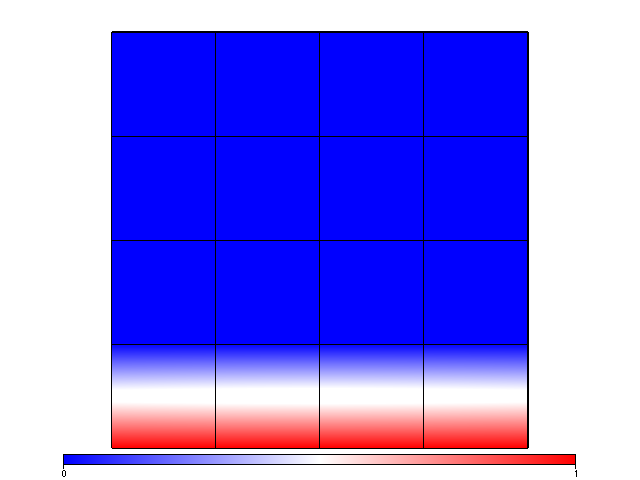

In [10]:
figtemp = plt.Figure()
figtemp.Surface(temperatureField, temperatureMesh, colours="blue white red")
figtemp.Mesh(temperatureMesh, colourBar = False)
figtemp.show()

System setup
-----

**Setup a heat equation solver**

The heat equation in two dimensions ($x$, $z$) is given by
\\[
\frac{\partial T}{\partial t} = k \left( \frac{\partial^2 T}{\partial x^2} + \frac{\partial^2 T}{\partial z^2} \right)
\\]
which in steady state can be writen as
\\[
\nabla(k\nabla)T = h
\\]
where $k$ is the conductivity, T is the temperature field (solved for) and $h$ is any additional heating term. See [here](https://en.wikipedia.org/wiki/Heat_equation) for more information on the heat equation.

To setup the heat equation using underworld the temperature field, conductivity and boundary conditions are passed to a system function (next cell). The system is then solved using the *.solve* function (see main loop below).

In [11]:
heatequation = uw.systems.SteadyStateHeat(temperatureField=temperatureField, conductivityFn=1.0, conditions=[tempBC,])

Main time loop
-----

Generally underworld will solve a dynamical system over a series of timesteps. In this particular case we seek the steady-state solution of the heat equation, which is a special case involving a single solve.

Solving the heat equation system setup above is done by the following command.


In [12]:
heatequation.solve()

**Plot final temperature field**

The resulting temperature field is now in steady state. To see this we re-run the plotter used above.

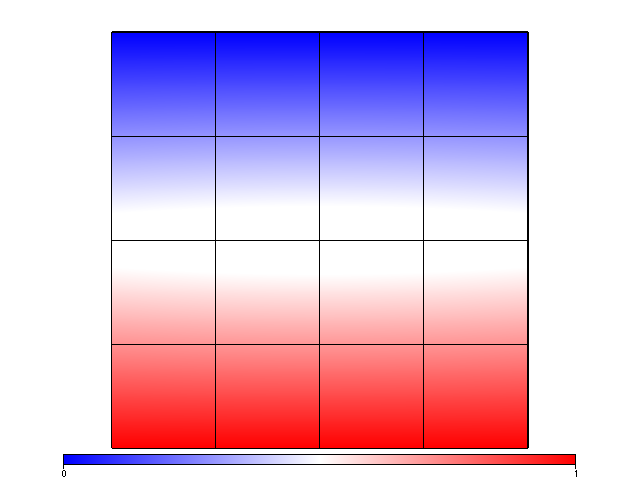

In [13]:
figtemp = plt.Figure()
figtemp.Surface(temperatureField, temperatureMesh, colours="blue white red")
figtemp.Mesh(temperatureMesh, colourBar = False)
figtemp.show()

Assuming everything ran correctly, the temperature field should be in steady-state, i.e. a smooth gradient from the top minimum temperature to the bottom maximum temperature.